### Programming for Biomedical Informatics
#### Week 6 - Differential Gene Expression Analysis

We're going to perform some differential expression analysis using the PyDESeq2 package using an RNA-Seq dataset from NCBI-GEO

In [5]:
'''
Sources of Data

Original Publication
Tomaiuolo P, Piras IS, Sain SB, Picinelli C, Baccarin M, Castronovo P, Morelli MJ, Lazarevic D, Scattoni ML, Tonon G, Persico AM.
RNA sequencing of blood from sex- and age-matched discordant siblings supports immune and transcriptional dysregulation in autism spectrum disorder.
Sci Rep. 2023 Jan 16;13(1):807. doi: 10.1038/s41598-023-27378-w. PMID: 36646776; PMCID: PMC9842630.

GEO Entry: GSE212645
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE212645

meta-data file
https://ftp.ncbi.nlm.nih.gov/geo/series/GSE212nnn/GSE212645/matrix/GSE212645_series_matrix.txt.gz

raw data file
https://www.ncbi.nlm.nih.gov/geo/download/?type=rnaseq_counts&acc=GSE212645&format=file&file=GSE212645_raw_counts_GRCh38.p13_NCBI.tsv.gz

normalised data file
https://www.ncbi.nlm.nih.gov/geo/download/?type=rnaseq_counts&acc=GSE212645&format=file&file=GSE212645_norm_counts_FPKM_GRCh38.p13_NCBI.tsv.gz

genome annotation file
https://www.ncbi.nlm.nih.gov/geo/download/?format=file&type=rnaseq_counts&file=Human.GRCh38.p13.annot.tsv.gz
'''

'\nSources of Data\n\nOriginal Publication\nTomaiuolo P, Piras IS, Sain SB, Picinelli C, Baccarin M, Castronovo P, Morelli MJ, Lazarevic D, Scattoni ML, Tonon G, Persico AM.\nRNA sequencing of blood from sex- and age-matched discordant siblings supports immune and transcriptional dysregulation in autism spectrum disorder.\nSci Rep. 2023 Jan 16;13(1):807. doi: 10.1038/s41598-023-27378-w. PMID: 36646776; PMCID: PMC9842630.\n\nGEO Entry: GSE212645\nhttps://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE212645\n\nmeta-data file\nhttps://ftp.ncbi.nlm.nih.gov/geo/series/GSE212nnn/GSE212645/matrix/GSE212645_series_matrix.txt.gz\n\nraw data file\nhttps://www.ncbi.nlm.nih.gov/geo/download/?type=rnaseq_counts&acc=GSE212645&format=file&file=GSE212645_raw_counts_GRCh38.p13_NCBI.tsv.gz\n\nnormalised data file\nhttps://www.ncbi.nlm.nih.gov/geo/download/?type=rnaseq_counts&acc=GSE212645&format=file&file=GSE212645_norm_counts_FPKM_GRCh38.p13_NCBI.tsv.gz\n\ngenome annotation file\nhttps://www.ncbi.nlm.n

In [6]:
#read in the meta-data
# we need to skip the first 38 rows as they contain project rather than sample meta-data
import pandas as pd
metadata = pd.read_csv('./data/GSE212645_series_matrix.txt.gz', sep='\t', skiprows=38, header=None)

# we now tidy this up and retain the information we need
# keep the rows we need
row_numbers = [0,8,10,11,12]
metadata = metadata.iloc[row_numbers]

# replace column 0 values with the list below
new_feature_names = ['number','gender', 'status', 'family', 'treatment']
metadata.iloc[:,0] = new_feature_names

# make the first row the column names and remove the first row
metadata.columns = metadata.iloc[0]
metadata = metadata.iloc[1:]
metadata.set_index('number', append=False, inplace=True)

# # transpose the data frame
metadata = metadata.T

# # reset the index and rename the first column
metadata.reset_index(inplace=True)
metadata.rename(columns={0: 'sample_no'}, inplace=True)

# tidy up the column contents
metadata['gender'] = metadata['gender'].str.replace('Sex: ', '')
metadata['status'] = metadata['status'].str.replace('genotype: ', '')
metadata['family'] = metadata['family'].str.replace('family: ', '')
metadata['treatment'] = metadata['treatment'].str.replace('treatment: ', '')

metadata.set_index('sample_no', inplace=True)
metadata.index.name = None

#change index name to sample_id
metadata.index.name = 'sample_id'

metadata.head()

number,gender,status,family,treatment
sample_id,,,,
GSM6542253,F,ASD,F1,no
GSM6542254,F,SIB,F1,no
GSM6542255,M,ASD,F2,no
GSM6542256,M,SIB,F2,no
GSM6542257,M,ASD,F3,no


In [7]:
# retrive the raw data file

raw_data_url = 'https://www.ncbi.nlm.nih.gov/geo/download/?type=rnaseq_counts&acc=GSE212645&format=file&file=GSE212645_raw_counts_GRCh38.p13_NCBI.tsv.gz'

# download the file and save in the ./data directory
import urllib.request
import os

urllib.request.urlretrieve(raw_data_url, './data/GSE212645_raw_counts_GRCh38.p13_NCBI.tsv.gz')

#read directly into a data frame
import pandas as pd

raw_counts = pd.read_csv('./data/GSE212645_raw_counts_GRCh38.p13_NCBI.tsv.gz', sep='\t', index_col=0)

In [8]:
raw_counts.head()

,GSM6542253,GSM6542254,GSM6542255,GSM6542256,GSM6542257,GSM6542258,GSM6542259,GSM6542260,GSM6542261,GSM6542262,...,GSM6542283,GSM6542284,GSM6542285,GSM6542286,GSM6542287,GSM6542288,GSM6542289,GSM6542290,GSM6542291,GSM6542292
GeneID,,,,,,,,,,,,,,,,,,,,,
100287102,265,88,204,178,360,458,350,183,251,134,...,88,22,12,200,42,64,31,30,24,188
653635,2267,478,1547,1677,1714,2297,4718,3009,725,631,...,420,227,339,1823,543,424,350,286,289,1823
102466751,44,18,30,25,48,75,130,62,29,25,...,19,5,11,35,20,12,16,6,8,38
107985730,0,0,0,0,1,1,4,1,1,0,...,0,0,0,1,0,0,1,0,0,2
100302278,3,0,0,0,0,0,3,2,1,0,...,0,0,0,0,0,0,0,0,0,1


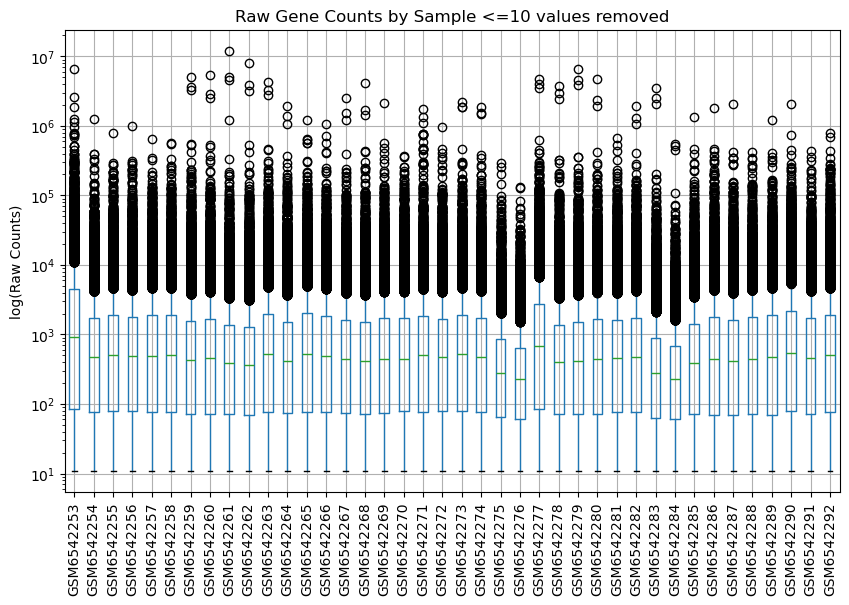

In [9]:
# plot a boxplot of the raw counts by sample
import matplotlib.pyplot as plt

exp_data = raw_counts.copy()

# convert all numbers less than or eual to 10 to nan
import numpy as np
exp_data[exp_data <= 10] = np.nan

plt.figure(figsize=(10,6))

exp_data.boxplot(rot=90)
plt.yscale('log')
plt.title('Raw Gene Counts by Sample <=10 values removed')
plt.ylabel('log(Raw Counts)')
plt.show()

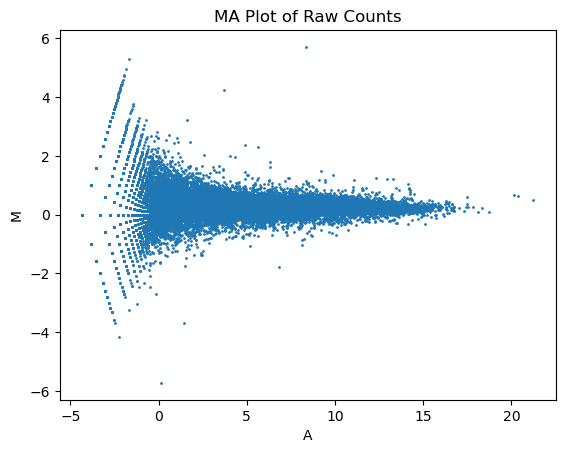

In [10]:
import numpy as np

# plot an MA plot of the raw counts from scratch

# find all the columns in raw_counts that have column headers matching the metadata index and have staus of 'ASD'ArithmeticError
asd_samples = metadata[metadata['status'] == 'ASD'].index

# find all the columns in raw_counts that have column headers matching the metadata index and have staus of 'SIB'
sib_samples = metadata[metadata['status'] == 'SIB'].index

# calculate the mean of the raw counts for each gene in the ASD samples
asd_mean = raw_counts[asd_samples].mean(axis=1)

# calculate the mean of the raw counts for each gene in the SIB samples
sib_mean = raw_counts[sib_samples].mean(axis=1)

# create a new data frame with these mean values and the gene names as the index
ma_data = pd.DataFrame({'ASD': asd_mean, 'SIB': sib_mean})

# calculate the M value with log2
ma_data['M'] = ma_data['ASD'].apply(np.log2) - ma_data['SIB'].apply(np.log2)

# calculate the A value with log2
ma_data['A'] = (ma_data['ASD'].apply(np.log2) + ma_data['SIB'].apply(np.log2)) / 2

# plot the data
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(ma_data['A'], ma_data['M'], s=1)
plt.xlabel('A')
plt.ylabel('M')
plt.title('MA Plot of Raw Counts')
plt.show()

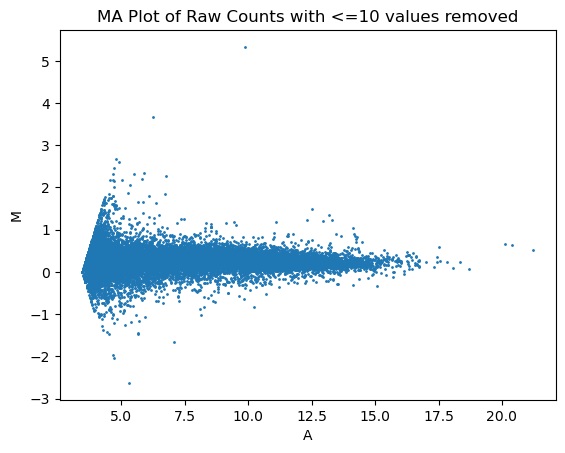

In [11]:
# and for the cleaned up test
# calculate the mean of the raw counts for each gene in the ASD samples
asd_mean = exp_data[asd_samples].mean(axis=1)

# calculate the mean of the raw counts for each gene in the SIB samples
sib_mean = exp_data[sib_samples].mean(axis=1)

# create a new data frame with these mean values and the gene names as the index
ma_data = pd.DataFrame({'ASD': asd_mean, 'SIB': sib_mean})

# calculate the M value with log2
ma_data['M'] = ma_data['ASD'].apply(np.log2) - ma_data['SIB'].apply(np.log2)

# calculate the A value with log2
ma_data['A'] = (ma_data['ASD'].apply(np.log2) + ma_data['SIB'].apply(np.log2)) / 2

# plot the data
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(ma_data['A'], ma_data['M'], s=1)
plt.xlabel('A')
plt.ylabel('M')
plt.title('MA Plot of Raw Counts with <=10 values removed')
plt.show()

In [12]:
# now lets use DESeq2 to perform differential expression

import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import *

SAVE = False  # whether to save the outputs of this notebook

if SAVE:
    # Replace this with the path to directory where you would like results to be
    # saved
    OUTPUT_PATH = "./data/asd_deseq2_results"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist

In [13]:
# we need the counts matrix transposed for DESeq2
# samples as rows and genes as columns
raw_counts = raw_counts.T

# keep genes with at least 10 counts in at least 2 samples
raw_counts = raw_counts[(raw_counts > 10).sum(axis=1) >= 2]

# change 'GeneID' to 'sample_id'
raw_counts.index.name = 'sample_id'

raw_counts.head()

GeneID,100287102,653635,102466751,107985730,100302278,645520,79501,100996442,729737,102725121,...,4538,4564,4575,4568,4540,4541,4556,4519,4576,4571
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM6542253,265,2267,44,0,3,1,1,290,2063,238,...,728057,1320,1365,1037,515207,170341,13209,516577,1171,1307
GSM6542254,88,478,18,0,0,0,0,331,2964,94,...,135364,253,272,280,89337,34711,2664,84603,268,356
GSM6542255,204,1547,30,0,0,0,0,1144,6524,197,...,95067,153,152,152,47921,18342,1593,54651,121,132
GSM6542256,178,1677,25,0,0,0,1,1096,5055,174,...,115056,232,227,218,56505,18148,1422,59748,170,182
GSM6542257,360,1714,48,1,0,1,0,1631,5963,377,...,143631,175,173,184,80157,24928,1911,73009,134,161


In [14]:
## set up the DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=raw_counts,
    metadata=metadata,
    design_factors="status",
    refit_cooks=True,
    inference=inference,
)

c:\Users\const\anaconda3\envs\pbi_env1\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
# compute normalisation factors to align data
dds.fit_size_factors()

dds.obsm["size_factors"]

Fitting size factors...
... done in 0.22 seconds.



array([3.3241258 , 1.03138801, 1.09719017, 1.04958374, 1.18703698,
       1.19938667, 0.98533361, 1.0755995 , 0.79846785, 0.78374556,
       1.35424032, 0.95947211, 1.39714073, 1.16380252, 0.99261956,
       0.975133  , 1.05074937, 0.95651264, 1.19132863, 1.08506366,
       1.1884336 , 1.02571393, 0.44068801, 0.33117263, 1.92248529,
       0.86885607, 0.9445427 , 1.03440895, 0.98515889, 1.06506545,
       0.49926766, 0.3505426 , 0.84355944, 1.12464469, 1.04958763,
       1.09112805, 1.29799615, 1.35426534, 1.09167244, 1.21272951])

Fitting dispersions...
... done in 30.29 seconds.



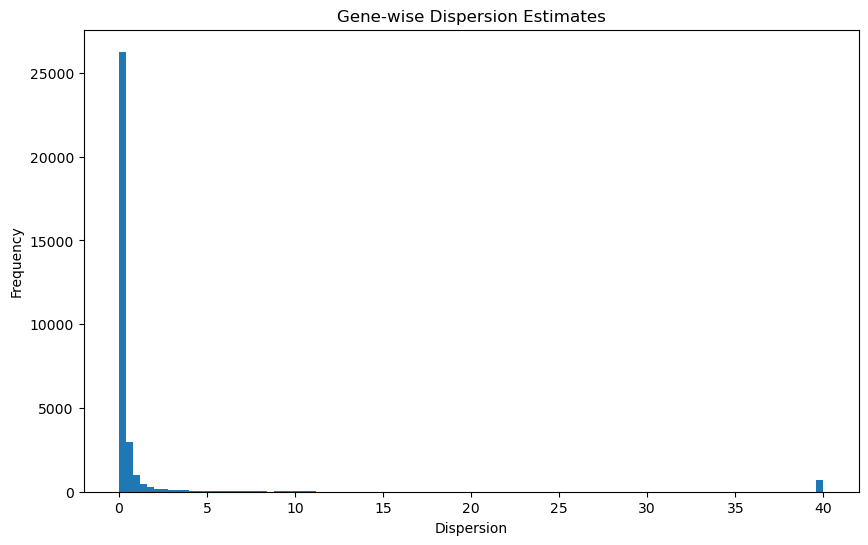

In [16]:
# fit gene-wise dispersion estimates
dds.fit_genewise_dispersions()

gene_dispersion = dds.varm["genewise_dispersions"]

#plot the dispersion estimates
plt.figure(figsize=(10,6))
plt.hist(gene_dispersion, bins=100)
plt.xlabel('Dispersion')
plt.ylabel('Frequency')
plt.title('Gene-wise Dispersion Estimates')
plt.show()

In [ ]:
'''Can see that most dispersion estimates are very small, but there are a couple that have a huge value - even after cleaning up data.'''

Fitting dispersion trend curve...
... done in 3.64 seconds.



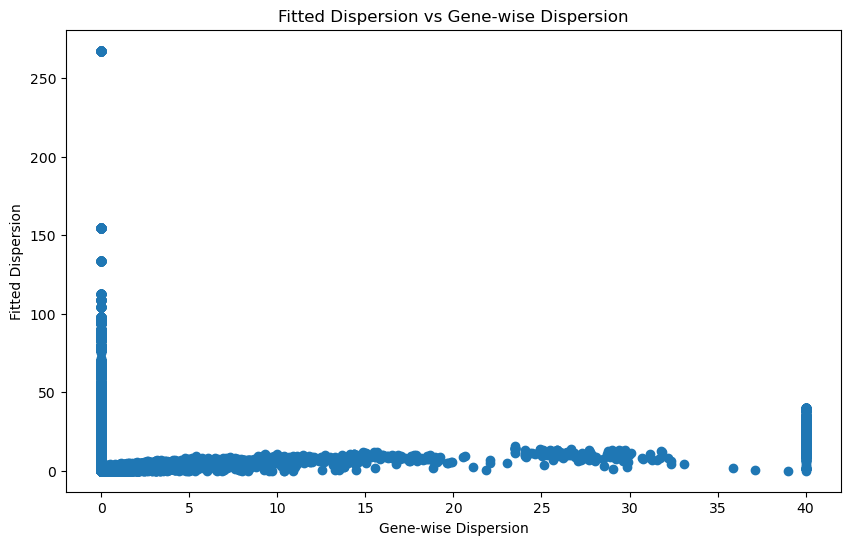

In [17]:
# fit dispersion trend coefficients
dds.fit_dispersion_trend()

dds.uns["trend_coeffs"]

fitted_dispersions = dds.varm["fitted_dispersions"]

# plot the fitted dispersion trend
plt.figure(figsize=(10,6))
plt.scatter(gene_dispersion, fitted_dispersions)
plt.xlabel('Gene-wise Dispersion')
plt.ylabel('Fitted Dispersion')
plt.title('Fitted Dispersion vs Gene-wise Dispersion')
plt.show()

In [18]:
# fit dispersion priors
dds.fit_dispersion_prior()
print(f"logres_prior={dds.uns['_squared_logres']},sigma_prior={dds.uns['prior_disp_var']}")

logres_prior=0.963626775309271,sigma_prior=0.9095858692715748


In [19]:
# fit MAP dispersions
dds.fit_MAP_dispersions()
dds.varm["MAP_dispersions"]
dds.varm["dispersions"]

Fitting MAP dispersions...
... done in 42.25 seconds.



array([0.52979413, 0.39500454, 0.36340792, ..., 0.08559492, 0.21188061,
       0.12539704])

Fitting LFCs...
... done in 20.28 seconds.



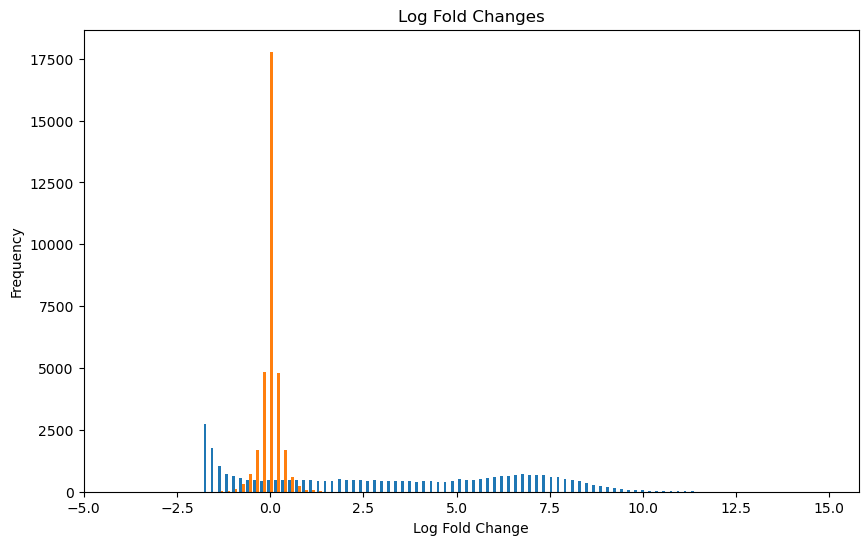

In [20]:
# fit log fold changes
dds.fit_LFC()
lfcs = dds.varm["LFC"]

# plot the log fold changes
plt.figure(figsize=(10,6))
plt.hist(lfcs, bins=100)
plt.xlabel('Log Fold Change')
plt.ylabel('Frequency')
plt.title('Log Fold Changes')
plt.show()

In [ ]:
'''Expected distribution in orange, actual values in blue.'''

In [21]:
'''Cook's distance = looks at how much the beta value variance deviates from what you expect (0 here).'''
# calculate cooks distanes and refit

# this step aims to identify outliers that would adversely affect the differential expresison analysis and filters them out
dds.calculate_cooks()
if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()

'''-> Minimises ability of outlier values to affect the fit of the model.'''

Calculating cook's distance...
... done in 0.39 seconds.

Replacing 292 outlier genes.

Fitting dispersions...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 0.48 seconds.

Fitting LFCs...
... done in 0.29 seconds.



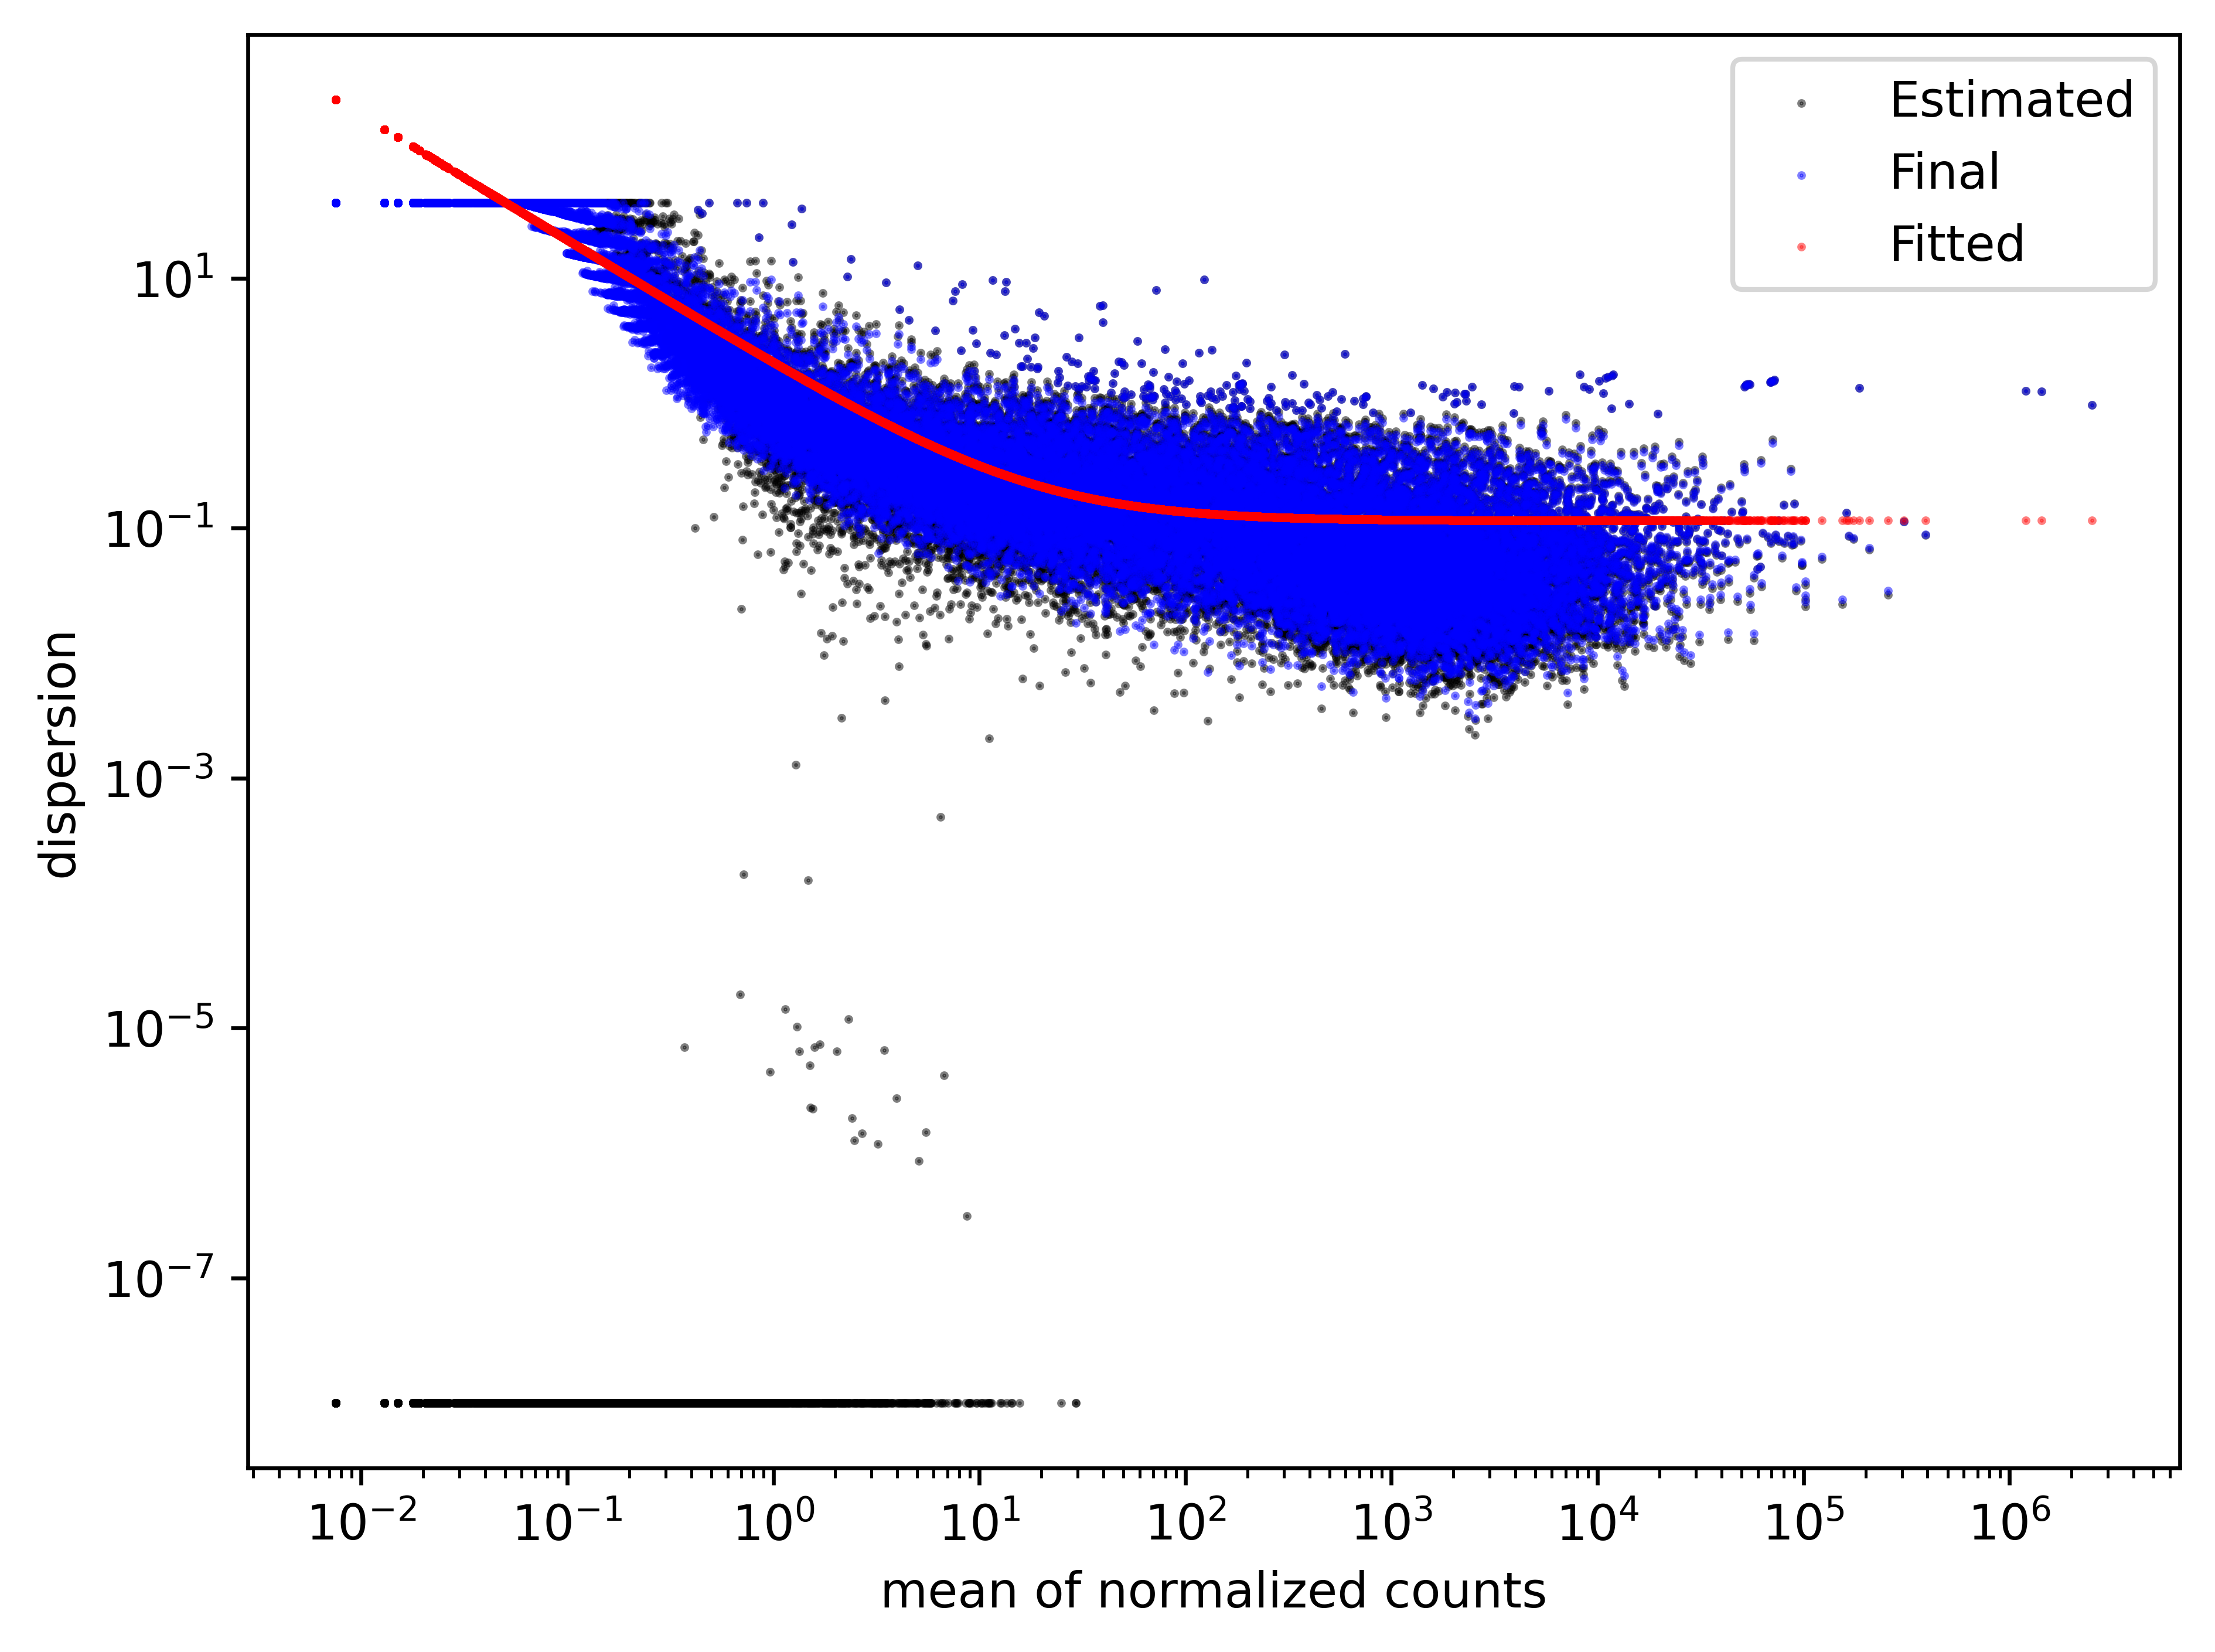

In [22]:
#let's look at the dispersion plot
dds.plot_dispersions()

In [23]:
# save the results so far
if SAVE:
    with open(os.path.join(OUTPUT_PATH, "dds_detailed_pipe.pkl"), "wb") as f:
        pkl.dump(dds, f)

In [24]:
# Statistical Analysis

In [25]:
# this is the main step where the differential expression is calculated
# here we can set our alpha value to 0.05, and also filter out genes with high cook's distance
stat_res = DeseqStats(dds, alpha=0.05, cooks_filter=True, independent_filter=True)

In [26]:
# run the Wald test
# this test effectively calculates the robustness of the beta value estaimation in the main DESeq2 GLM and then calculates the p-values based on the
# assumed normal distribution of the beta values
stat_res.run_wald_test()
stat_res.p_values

Running Wald tests...
... done in 9.81 seconds.



GeneID
100287102    0.624521
653635       0.593421
102466751    0.900544
107985730    0.719174
100302278    0.825568
               ...   
4541         0.678477
4556         0.732177
4519         0.769555
4576         0.835001
4571         0.306506
Length: 39376, dtype: float64

In [27]:
# filter these using the cook's distance
if stat_res.cooks_filter:
    stat_res._cooks_filtering()
stat_res.p_values

GeneID
100287102    0.624521
653635       0.593421
102466751    0.900544
107985730    0.719174
100302278    0.825568
               ...   
4541         0.678477
4556         0.732177
4519         0.769555
4576         0.835001
4571         0.306506
Length: 39376, dtype: float64

In [28]:
# now use the independent filtering to reduce the number of tests and hence reduces the multiple testing burden
if stat_res.independent_filter:
    stat_res._independent_filtering()
else:
    stat_res._p_value_adjustment()

stat_res.padj.sort_values(ascending=True)

'''Can see p-values of up to almost 1! These genes are most certainly not differentially expressed.'''

GeneID
4540         0.99996
653635       0.99996
102466751    0.99996
107985730    0.99996
100302278    0.99996
              ...   
114760           NaN
107987352        NaN
105377244        NaN
107987359        NaN
105379563        NaN
Name: 0, Length: 39376, dtype: float64

In [29]:
stat_res.summary()

Log2 fold change & Wald test p-value: status SIB vs ASD
               baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
GeneID                                                                        
100287102    130.625124        0.163790  0.334639  0.489453  0.624521  0.99996
653635      1004.148077        0.153290  0.287121  0.533885  0.593421  0.99996
102466751     35.154008       -0.035772  0.286237 -0.124975  0.900544  0.99996
107985730      0.627079        0.289301  0.804591  0.359563  0.719174  0.99996
100302278      0.214983       -0.365205  1.657091 -0.220389  0.825568  0.99996
...                 ...             ...       ...       ...       ...      ...
4541       30347.491956       -0.054364  0.131142 -0.414542  0.678477  0.99996
4556        2379.609158       -0.045019  0.131545 -0.342231  0.732177  0.99996
4519       89004.335998       -0.039105  0.133484 -0.292957  0.769555  0.99996
4576         201.855324        0.044287  0.212618  0.208292  0.835001  0.99

In [30]:
results = stat_res.results_df

sorted_results = results.sort_values(by='pvalue', ascending=True)

#convert the GeneID column to integers
sorted_results.index = sorted_results.index.map(int)
sorted_results.reset_index(inplace=True)

sorted_results.head()

# it's clear here that the p-value adjustment is very heavily penalising the p-values
'''Below are the differentially expressed genes, but none of them are significant according to our analysis.'''

,GeneID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,102724601,4.244670,-1.212028,0.303112,-3.998615,0.000064,0.99996
1,5354,1.489687,-2.478584,0.664153,-3.731947,0.000190,0.99996
2,387849,5.161698,2.089530,0.595169,3.510818,0.000447,0.99996
3,100379220,3.139475,1.562215,0.449283,3.477132,0.000507,0.99996
4,284119,19.407812,-0.669459,0.202381,-3.307905,0.000940,0.99996


In [31]:
# optionally save the results
# if SAVE:
#     with open(os.path.join(OUTPUT_PATH, "stat_results_detailed_pipe.pkl"), "wb") as f:
#         pkl.dump(stat_res, f)

In [32]:
# load up the genome annotation file so that we can look at the gene names

annotation_url = 'https://www.ncbi.nlm.nih.gov/geo/download/?format=file&type=rnaseq_counts&file=Human.GRCh38.p13.annot.tsv.gz'

# download the file and save in the ./data directory
import urllib.request
import os

urllib.request.urlretrieve(annotation_url, './data/Human.GRCh38.p13.annot.tsv.gz')

#read directly into a data frame
annotation = pd.read_csv('./data/Human.GRCh38.p13.annot.tsv.gz', sep='\t', index_col=0, low_memory=False)

#drop all columns except Symbol and Description
annotation = annotation[['Symbol', 'Description']]

annotation.head()

,Symbol,Description
GeneID,,
100287102,DDX11L1,DEAD/H-box helicase 11 like 1 (pseudogene)
653635,WASH7P,"WASP family homolog 7, pseudogene"
102466751,MIR6859-1,microRNA 6859-1
107985730,MIR1302-2HG,MIR1302-2 host gene
100302278,MIR1302-2,microRNA 1302-2


In [33]:
# merge the annotation with the results on the GeneID column
results = sorted_results.merge(annotation, left_on='GeneID', right_on='GeneID')

results.head(40)

,GeneID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Description
0,102724601,4.244670,-1.212028,0.303112,-3.998615,0.000064,0.99996,RABGAP1L-DT,RABGAP1L divergent transcript
1,5354,1.489687,-2.478584,0.664153,-3.731947,0.000190,0.99996,PLP1,proteolipid protein 1
2,387849,5.161698,2.089530,0.595169,3.510818,0.000447,0.99996,REP15,RAB15 effector protein
3,100379220,3.139475,1.562215,0.449283,3.477132,0.000507,0.99996,TMED11P,"transmembrane p24 trafficking protein 11, pseu..."
4,284119,19.407812,-0.669459,0.202381,-3.307905,0.000940,0.99996,CAVIN1,caveolae associated protein 1
5,105379203,5.659011,1.495649,0.460525,3.247707,0.001163,0.99996,LOC105379203,uncharacterized LOC105379203
6,162998,3.771461,2.370105,0.742586,3.191692,0.001414,0.99996,OR7D2,olfactory receptor family 7 subfamily D member 2
7,105374021,2.237417,-1.564801,0.492994,-3.174078,0.001503,0.99996,LOC105374021,uncharacterized LOC105374021
8,102723390,81.756339,0.896858,0.284691,3.150287,0.001631,0.99996,FRG1EP,"FSHD region gene 1 family member E, pseudogene"
9,10911,47.281880,-1.039997,0.330895,-3.142982,0.001672,0.99996,UTS2,urotensin 2


In [34]:
# now lets go back and pick up the results for the genes cited in the paper to see what the p-values are
# (the paper states these 6 genes a differentially expressed)
target_genes = ['EGR1', 'EGR2', 'IGKV6D-21', 'IGKV3D-15', 'S100B', 'CD80']

target_gene_results = results[results['Symbol'].isin(target_genes)]

target_gene_results.head()

,GeneID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Description
12,6285,305.886048,1.116386,0.358549,3.113626,0.001848,0.99996,S100B,S100 calcium binding protein B
29,28870,42.031911,1.314869,0.467290,2.813821,0.004896,0.99996,IGKV6D-21,immunoglobulin kappa variable 6D-21 (non-funct...
259,941,27.759759,-0.380420,0.175189,-2.171480,0.029895,0.99996,CD80,CD80 molecule
472,1959,42.153707,-0.414054,0.210915,-1.963128,0.049631,0.99996,EGR2,early growth response 2
567,1958,125.970922,-0.430311,0.228797,-1.880756,0.060005,0.99996,EGR1,early growth response 1


In [35]:
#lets go back and find the log normlised counts for these genes
# merge the ma_data with the target_gene_results on the GeneID column

combined = target_gene_results.merge(ma_data, left_on='GeneID', right_index=True)

combined.head(10)

,GeneID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Description,ASD,SIB,M,A
12,6285,305.886048,1.116386,0.358549,3.113626,0.001848,0.99996,S100B,S100 calcium binding protein B,196.800000,402.350000,-1.031721,8.136447
29,28870,42.031911,1.314869,0.467290,2.813821,0.004896,0.99996,IGKV6D-21,immunoglobulin kappa variable 6D-21 (non-funct...,30.312500,83.250000,-1.457537,5.650610
259,941,27.759759,-0.380420,0.175189,-2.171480,0.029895,0.99996,CD80,CD80 molecule,41.368421,25.888889,0.676197,5.032360
472,1959,42.153707,-0.414054,0.210915,-1.963128,0.049631,0.99996,EGR2,early growth response 2,64.894737,37.736842,0.782128,5.628966
567,1958,125.970922,-0.430311,0.228797,-1.880756,0.060005,0.99996,EGR1,early growth response 1,253.250000,105.750000,1.259905,7.354466
5200,28875,301.565526,-0.374482,0.357934,-1.046233,0.295454,0.99996,IGKV3D-15,immunoglobulin kappa variable 3D-15,339.900000,265.350000,0.357214,8.230360


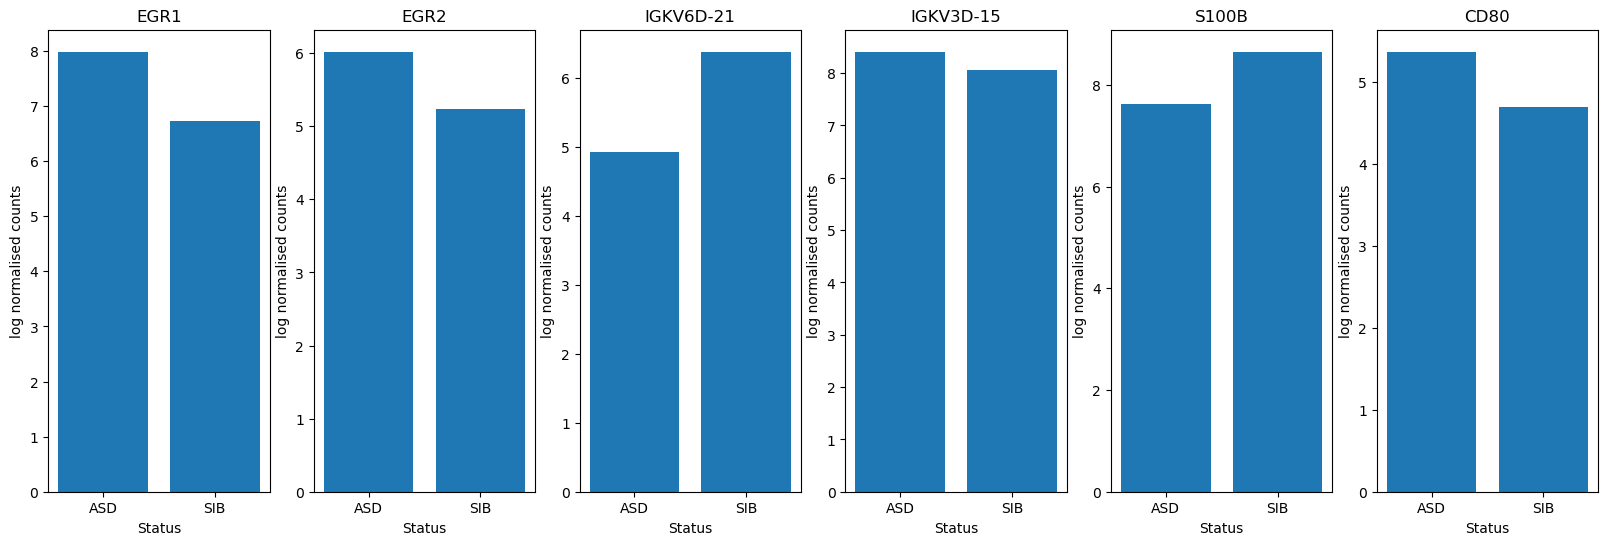

In [36]:
# next we plot paired barcharts for each Symbol showing the log normalised counts for each gene in the ASD and SIB samples using matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 6, figsize=(20, 6))

for i, gene in enumerate(target_genes):
    #take the log2 values of the counts
    combined.loc[combined['Symbol'] == gene, ['ASD', 'SIB']] = combined.loc[combined['Symbol'] == gene, ['ASD', 'SIB']].apply(np.log2)
    ax[i].bar(['ASD', 'SIB'], combined.loc[combined['Symbol'] == gene, ['ASD', 'SIB']].values[0])
    ax[i].set_title(gene)
    ax[i].set_ylabel('log normalised counts')
    ax[i].set_xlabel('Status')

plt.show()

# the trends are the same as in the paper, but the p-values are not significant - NB in the paper only EGR1 and IGKV3D-15 were significant after correction.